In [5]:
import pymysql
import pandas as pd

In [6]:
# Connecting to database
db_config = {
    "host": "localhost", 
    "user": "root",       
    "password": "root123",  
    "database": "sales"  
}

In [7]:
#Reading the dataframes
df_od = pd.read_csv("order_detail.csv")
df_sd = pd.read_csv("sku_detail.csv")
df_pd = pd.read_csv("payment_detail.csv")
df_cd = pd.read_csv("customer_detail.csv")

In [8]:
# Renaming column names in order to avoid duplicate column names while merging
df_sd.rename(columns={'id':'sku_id'}, inplace=True)
df_cd.rename(columns={'id':'customer_id'}, inplace=True)
df_pd.rename(columns={'id':'payment_id'}, inplace=True)

In [9]:
# Merging the dataframes using left join
df = pd.DataFrame(df_od\
                  # Merge order_detail with sku_detail on column sku_id
                  .merge(df_sd, how='left', on='sku_id')\
                  # Merge the result to customer_detail on column customer_id
                  .merge(df_cd, how='left', on='customer_id')\
                  # Merge the result to payment_detail on column payment_id
                  .merge(df_pd, how='left', on='payment_id')
                  )

In [10]:
# Ensure both columns have the same data type before merging
df_pd['payment_id'] = df_pd['payment_id'].astype(str)  
df_od['id'] = df_od['id'].astype(str)                 

# Display info about the resulting DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               11528 non-null  object 
 1   customer_id      11528 non-null  object 
 2   order_date       11528 non-null  object 
 3   sku_id           11528 non-null  object 
 4   price            11528 non-null  int64  
 5   qty_ordered      11528 non-null  int64  
 6   before_discount  11528 non-null  float64
 7   discount_amount  11528 non-null  float64
 8   after_discount   11528 non-null  float64
 9   is_gross         11528 non-null  int64  
 10  is_valid         11528 non-null  int64  
 11  is_net           11528 non-null  int64  
 12  payment_id       11528 non-null  int64  
 13  sku_name         11528 non-null  object 
 14  base_price       11528 non-null  float64
 15  cogs             11528 non-null  float64
 16  category         11528 non-null  object 
 17  registered_d

In [11]:
# change columns to datetime format using for loop
# use pandas.to_datetime to convert
for x in ['order_date', 'registered_date']:
  df[x] = pd.to_datetime(df[x])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               11528 non-null  object        
 1   customer_id      11528 non-null  object        
 2   order_date       11528 non-null  datetime64[ns]
 3   sku_id           11528 non-null  object        
 4   price            11528 non-null  int64         
 5   qty_ordered      11528 non-null  int64         
 6   before_discount  11528 non-null  float64       
 7   discount_amount  11528 non-null  float64       
 8   after_discount   11528 non-null  float64       
 9   is_gross         11528 non-null  int64         
 10  is_valid         11528 non-null  int64         
 11  is_net           11528 non-null  int64         
 12  payment_id       11528 non-null  int64         
 13  sku_name         11528 non-null  object        
 14  base_price       11528 non-null  float

In [12]:
"""Question 1: 
Top 5 Products by Sales in 2022 for the "Mobiles & Tablets" Category Scenario: 
The Marketing Team is preparing for a Year-End Festival and needs to identify the top 5 products in the "Mobiles & Tablets" category that had the highest sales quantities in 2022. The products should be filtered to ensure only valid orders are included.
 Requirements: • Filter the data to include only products from the "Mobiles & Tablets" category in 2022, where the is_valid feature is set to 1.
 • Group the data by sku_name and category, and sum the qty_ordered for each product.
 • Rank the products based on their total sales quantity in descending order.
 • Display the top 5 products with the highest sales quantities. 
• Generate a horizontal bar chart showing the top 5 products by quantity. 
Key Features to Use: • category • order_date (for filtering by year) • is_valid (to filter valid orders) • sku_name (for product names) • qty_ordered (for sales quantities)
"""


'Question 1: \nTop 5 Products by Sales in 2022 for the "Mobiles & Tablets" Category Scenario: \nThe Marketing Team is preparing for a Year-End Festival and needs to identify the top 5 products in the "Mobiles & Tablets" category that had the highest sales quantities in 2022. The products should be filtered to ensure only valid orders are included.\n Requirements: • Filter the data to include only products from the "Mobiles & Tablets" category in 2022, where the is_valid feature is set to 1.\n • Group the data by sku_name and category, and sum the qty_ordered for each product.\n • Rank the products based on their total sales quantity in descending order.\n • Display the top 5 products with the highest sales quantities. \n• Generate a horizontal bar chart showing the top 5 products by quantity. \nKey Features to Use: • category • order_date (for filtering by year) • is_valid (to filter valid orders) • sku_name (for product names) • qty_ordered (for sales quantities)\n'

In [13]:
Top_5_products = pd.DataFrame(\
                          # filtering the columns as needed
                          df[(df['category']=='Mobiles & Tablets') & (df['is_valid']==1) & (df['order_date'].dt.year == 2022)]\
                          # groupby quantity
                          .groupby(by=['sku_name','category'])['qty_ordered'].sum()\
                          # reset the index to convert result into dataframe
                          .reset_index(name='qty_ordered')\
                          #renaming the columns
                          .rename(columns={
                                            'sku_name': 'Product_Name',
                                            'category': 'Category',
                                            'qty_ordered':'Sales_Quantity'
                                          }
                                )
                          # sorting the values from the largest to the smallest
                          .sort_values(by='Sales_Quantity', ascending=False)\
                          # selecting top 5 rows
                          .head(5).reset_index(drop=True)
                          )
Top_5_products

,Product_Name,Category,Sales_Quantity
0,IDROID_BALRX7-Gold,Mobiles & Tablets,2000
1,IDROID_BALRX7-Jet black,Mobiles & Tablets,62
2,Infinix Hot 4-Gold,Mobiles & Tablets,30
3,samsung_Grand Prime Plus-Black,Mobiles & Tablets,22
4,infinix_Zero 4-Grey,Mobiles & Tablets,20


<Axes: title={'center': 'TOP 5 Products'}, xlabel='Product Name', ylabel='Sales Quantity'>

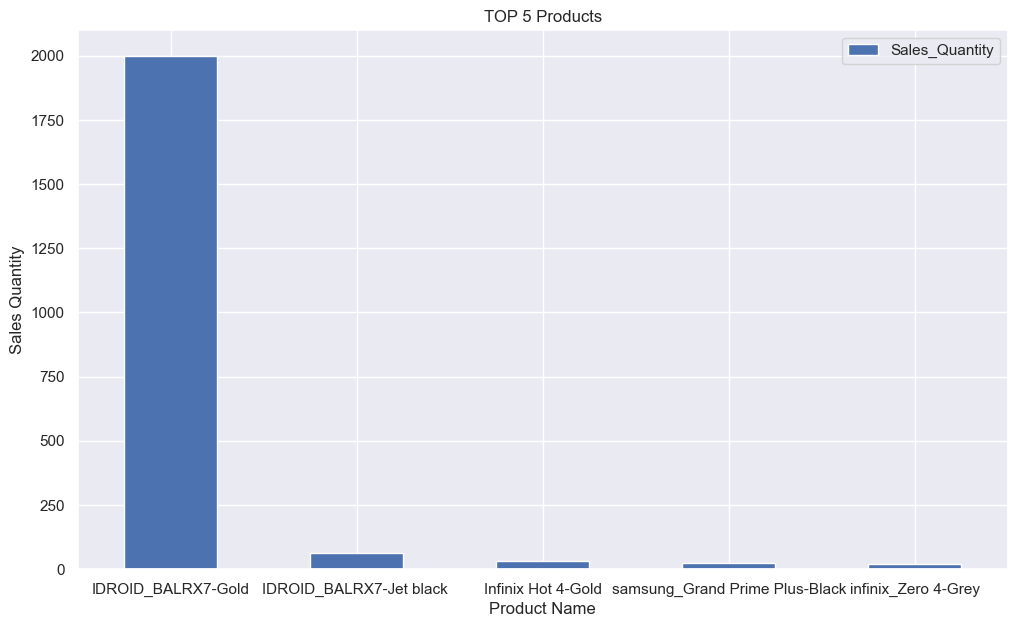

In [14]:
# show the chart
import seaborn as sns

#sorting the values to plot the graph
Top_5_products.sort_values(by='Sales_Quantity', ascending=False, inplace=True)

sns.set()
Top_5_products.plot(x='Product_Name',
           y=['Sales_Quantity'],
           kind='bar',
           grid = True,
           xlabel = 'Product Name',
           ylabel = 'Sales Quantity',
           figsize=(12,7),
           rot = 0,
           title = 'TOP 5 Products',
           table = False,
           secondary_y = False)

In [15]:
"""Question 2
Analyzing Sales Decrease in the "Others" Category Between 2021 and 2022 Scenario: 
The Warehouse Team has observed a surplus in the stock of "Others" category products at the end of 2022. 
They would like to know if sales have declined in 2022 compared to 2021. 
Additionally, they want to see the 20 products that experienced the largest decrease in sales.
 Requirements: 1. Create two datasets: o One for sales data in 2021 (qty_ordered for "Others" category).
                                       o One for sales data in 2022 (qty_ordered for "Others" category).
 2. Merge the datasets and calculate the sales difference between 2022 and 2021. 
 3. Calculate the percentage change in sales and classify it as "DOWN", "UP", or "FAIR".
 4. Sort the products by the largest decrease in sales and show the top 20 products. 
 5. Create a horizontal bar chart to display the products with the largest decrease in sales between 2022 and 2021.
 Key Features to Use: • category • order_date (for filtering by year) • is_valid • sku_name • qty_ordered*."""


'Question 2\nAnalyzing Sales Decrease in the "Others" Category Between 2021 and 2022 Scenario: \nThe Warehouse Team has observed a surplus in the stock of "Others" category products at the end of 2022. \nThey would like to know if sales have declined in 2022 compared to 2021. \nAdditionally, they want to see the 20 products that experienced the largest decrease in sales.\n Requirements: 1. Create two datasets: o One for sales data in 2021 (qty_ordered for "Others" category).\n                                       o One for sales data in 2022 (qty_ordered for "Others" category).\n 2. Merge the datasets and calculate the sales difference between 2022 and 2021. \n 3. Calculate the percentage change in sales and classify it as "DOWN", "UP", or "FAIR".\n 4. Sort the products by the largest decrease in sales and show the top 20 products. \n 5. Create a horizontal bar chart to display the products with the largest decrease in sales between 2022 and 2021.\n Key Features to Use: • category • o

In [16]:
#Calculating sales for the year 2021
data_2021 = pd.DataFrame(\
                           # filtering the columns as needed 
                           df[ (df['category']== 'Others') & (df['is_valid']==1) & (df['order_date'].dt.year == 2021)]\
                           # groupby quantity
                           .groupby(by=['category','sku_name'])['qty_ordered'].sum()\
                           # convert to dataframe
                           .reset_index(name='Sales_2021')
                           # #renaming the columns
                           .rename(columns={'qty_ordered': 'Sales_2021',
                                         'sku_name': 'Product_Name'})
                           # sorting the values from the largest to the smallest
                          .sort_values(by='Sales_2021', ascending=False)\
                         )

#Calculating sales for the year 2022
data_2022 = pd.DataFrame(\
                          # filtering the columns as needed 
                          df[ (df['category']== 'Others') & (df['is_valid']==1) & (df['order_date'].dt.year == 2022)]\
                          # groupby quantity
                          .groupby(by=['category','sku_name'])['qty_ordered'].sum()\
                          # convert to dataframe
                          .reset_index(name='Sales_2022')
                          #renaming the columns
                          .rename(columns={'qty_ordered': 'Sales_2022',
                                             'sku_name': 'Product_Name'})
                          # sorting the values from the largest to the smallest
                          .sort_values(by='Sales_2022', ascending=False)\
                        )
# joining the 2 dataframes
data_2021_2022 = data_2021.merge(data_2022[['Product_Name', 'Sales_2022']], how='outer')


data_2021_2022


,category,Product_Name,Sales_2021,Sales_2022
0,NaN,AL Khair_Baby Oil 50ml,NaN,2.0
1,Others,Aladdin_Wrench_Snap N Grip_01,2.0,NaN
2,Others,Aladdin_bike_cover,6.0,4.0
3,NaN,Alerashine_sku-09-XL,NaN,2.0
4,Others,Am-PTV_ATS-004-M,10.0,NaN
...,...,...,...,...
157,Others,stripyinterior_100006,2.0,NaN
158,NaN,sukoonbundle-sukoon10-cj_CJPOISL,NaN,2.0
159,NaN,test-product-00,NaN,2.0
160,Others,tucano_IPD7AN-BK,2.0,NaN


In [17]:
# fill "NaN" with "Others" in column "category"
data_2021_2022['category'].fillna('Others', inplace=True)

# fill "NaN" with 0 for other values
data_2021_2022.fillna(0, inplace=True)

# Calculating and adding the column "Sales_Diff"
data_2021_2022['Sales_Diff'] = data_2021_2022['Sales_2022'] - data_2021_2022['Sales_2021']

# show the data
data_2021_2022


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_10792\2221912550.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_2021_2022['category'].fillna('Others', inplace=True)


,category,Product_Name,Sales_2021,Sales_2022,Sales_Diff
0,Others,AL Khair_Baby Oil 50ml,0.0,2.0,2.0
1,Others,Aladdin_Wrench_Snap N Grip_01,2.0,0.0,-2.0
2,Others,Aladdin_bike_cover,6.0,4.0,-2.0
3,Others,Alerashine_sku-09-XL,0.0,2.0,2.0
4,Others,Am-PTV_ATS-004-M,10.0,0.0,-10.0
...,...,...,...,...,...
157,Others,stripyinterior_100006,2.0,0.0,-2.0
158,Others,sukoonbundle-sukoon10-cj_CJPOISL,0.0,2.0,2.0
159,Others,test-product-00,0.0,2.0,2.0
160,Others,tucano_IPD7AN-BK,2.0,0.0,-2.0


In [19]:
# Caluclating and adding the column "Percent Change"
data_2021_2022['Percent change'] = round(((data_2021_2022['Sales_Diff'])/ data_2021_2022['Sales_2021'])*100,2)

#defining the function "updwon_check"
def updown_check(value):
    if value > 0:
        return 'Up'
    elif value < 0:
        return 'Down'
    else:
        return 'Fair'

#callling the function
data_2021_2022['Remark'] = data_2021_2022['Percent change'].apply(updown_check)

# sorting values from the  largest to smallest by "Percent change"
data_2021_2022.sort_values(by='Percent change', ascending=True, inplace=True)

# reset the index
data_2021_2022.reset_index(drop=True, inplace=True)

data_2021_2022

,category,Product_Name,Sales_2021,Sales_2022,Sales_Diff,Percent change,Remark
0,Others,Aladdin_Wrench_Snap N Grip_01,2.0,0.0,-2.0,-100.0,Down
1,Others,BFV_Black Friday voucher Rs 2000,2.0,0.0,-2.0,-100.0,Down
2,Others,BFV_Black Friday voucher Rs 1500,2.0,0.0,-2.0,-100.0,Down
3,Others,Am-PTV_ATS-004-M,10.0,0.0,-10.0,-100.0,Down
4,Others,Careem_25000 Credits,2.0,0.0,-2.0,-100.0,Down
...,...,...,...,...,...,...,...
157,Others,stripyinterior_100004,0.0,2.0,2.0,inf,Up
158,Others,interwood_HA-HLZ9A115-38562,0.0,2.0,2.0,inf,Up
159,Others,qzs_27360-Large,0.0,2.0,2.0,inf,Up
160,Others,test-product-00,0.0,2.0,2.0,inf,Up


In [20]:
 # selecting top 20 rows
Top_20_Products = data_2021_2022.head(20)

# sorting values from the  largest to smallest by "Sales_Diff"
Top_20_Products.sort_values(by='Sales_Diff', ascending=True, inplace=True)

Top_20_Products

C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_10792\1209232046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_20_Products.sort_values(by='Sales_Diff', ascending=True, inplace=True)


,category,Product_Name,Sales_2021,Sales_2022,Sales_Diff,Percent change,Remark
14,Others,Dawlance_MD 10 + DWB 600,46.0,0.0,-46.0,-100.0,Down
3,Others,Am-PTV_ATS-004-M,10.0,0.0,-10.0,-100.0,Down
19,Others,MEGUIAR_G13616,4.0,0.0,-4.0,-100.0,Down
1,Others,BFV_Black Friday voucher Rs 2000,2.0,0.0,-2.0,-100.0,Down
4,Others,Careem_25000 Credits,2.0,0.0,-2.0,-100.0,Down
5,Others,BO_Rectangular Sea Pool,2.0,0.0,-2.0,-100.0,Down
6,Others,BO_Hippo figured Child Seat,2.0,0.0,-2.0,-100.0,Down
0,Others,Aladdin_Wrench_Snap N Grip_01,2.0,0.0,-2.0,-100.0,Down
7,Others,BOOSTER CABLE 500AMP,2.0,0.0,-2.0,-100.0,Down
8,Others,Careem_50000 Credits,2.0,0.0,-2.0,-100.0,Down


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_10792\1913764800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Top_20_Products.sort_values(by='Sales_Diff', ascending=False, inplace=True)


Text(0.5, 0, 'Sales_Diff')

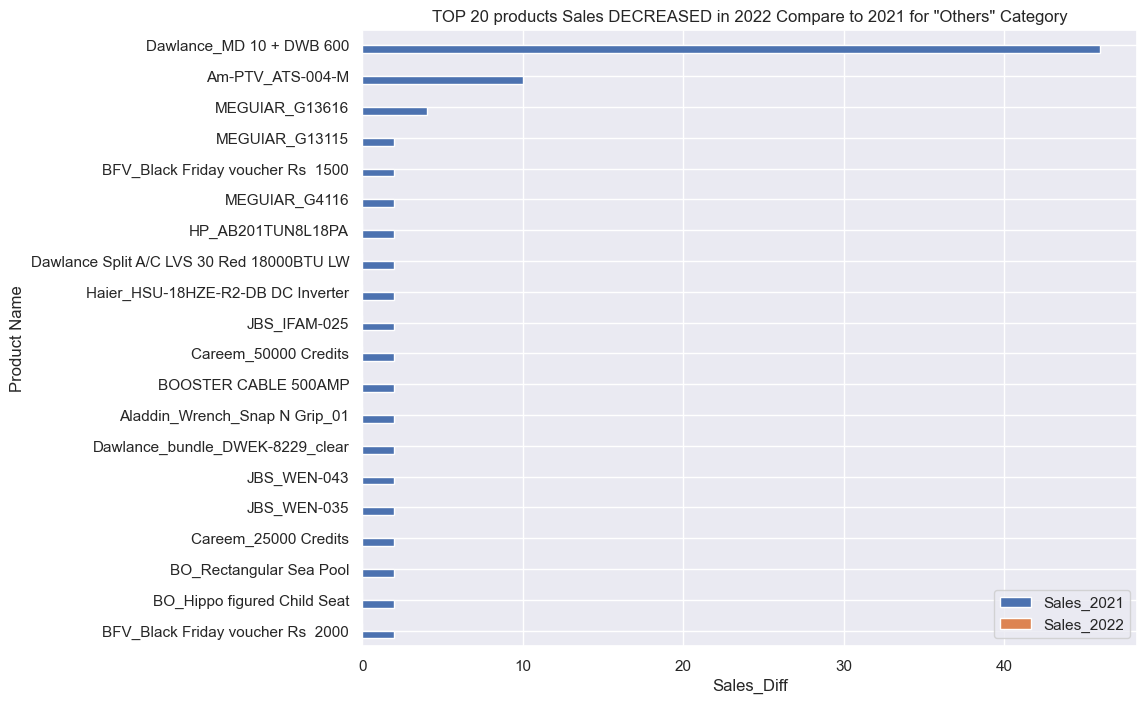

In [25]:
import matplotlib.pyplot as plt
#sorting the values to plot the graph
Top_20_Products.sort_values(by='Sales_Diff', ascending=False, inplace=True)
sns.set()
Top_20_Products.plot(x='Product_Name',\
                      y=['Sales_2021','Sales_2022'],\
                      kind='barh',\
                      figsize=(10, 8))
plt.title('TOP 20 products Sales DECREASED in 2022 Compare to 2021 for "Others" Category')
plt.ylabel('Product Name')
plt.xlabel('Sales_Diff')

In [26]:
"""Question 3 Identifying Customers Who Completed Checkout but Didn't Pay in 2022 Scenario: 
The Digital Marketing Team wants to identify customers who completed the checkout process but did not make a payment in 2022.
 This will help them reach out for promotional purposes. 
Requirements: 
• Filter the data to find records where is_gross is 1 (indicating completed checkout process but did not make a payment)
• Retrieve the customer_id and registered_date for these records. 
• Ensure there are no duplicate customer_id entries. 
• Share the compiled data with the Marketing Team.
 Key Features to Use: • is_gross (for checkout status) • is_valid, is_net (to filter invalid or net transactions) 
 • order_date (for filtering by year) • customer_id • registered_dateckout but no payment), is_valid is 0, and is_net is 0, for the year 2022.
"""

"Question 3 Identifying Customers Who Completed Checkout but Didn't Pay in 2022 Scenario: \nThe Digital Marketing Team wants to identify customers who completed the checkout process but did not make a payment in 2022.\n This will help them reach out for promotional purposes. \nRequirements: \n• Filter the data to find records where is_gross is 1 (indicating completed checkout process but did not make a payment)\n• Retrieve the customer_id and registered_date for these records. \n• Ensure there are no duplicate customer_id entries. \n• Share the compiled data with the Marketing Team.\n Key Features to Use: • is_gross (for checkout status) • is_valid, is_net (to filter invalid or net transactions) \n • order_date (for filtering by year) • customer_id • registered_dateckout but no payment), is_valid is 0, and is_net is 0, for the year 2022.\n"

In [31]:
cs_gross_data = (
    df.loc[
         # filtering the columns as needed
        (df['is_gross'] == 1) &
        (df['is_valid'] == 0) &
        (df['is_net'] == 0) &
        (df['order_date'].dt.year == 2022),
        ['customer_id', 'registered_date']
    ]
    #selecting unique values
    .drop_duplicates(subset=['customer_id'])
    #reseting the index
    .reset_index(drop=True)
)
# show the data
cs_gross_data

,customer_id,registered_date
0,C993531L,2021-11-08
1,C652751L,2022-07-19
2,C189144L,2022-07-01
3,C224183L,2022-04-07
4,C907186L,2022-05-08
...,...,...
815,C118563L,2022-06-07
816,C217246L,2022-08-04
817,C577176L,2022-06-01
818,C744990L,2022-05-21


In [27]:
"""Question 4
Comparing Weekend and Weekday Sales in Q4 2022 Scenario: 
The Campaign Team wants to evaluate the effectiveness of their weekend promotional campaigns (Saturdays and Sundays)
 between October and December 2022 by comparing the average daily sales during weekends vs weekdays.
 Requirements: 1. Calculate the average daily sales (before_discount) for weekends (Saturdays and Sundays) and weekdays (Monday to Friday) 
 for each month (October, November, and December 2022).
 2. Calculate the average sales for weekends vs weekdays for the entire three-month period. 
 3. Share insights on whether sales increased during weekends.
 Key Features to Use: • order_date (for filtering by date and identifying days of the week)
 • before_discount (for sales data) • month_id, month_name, day_name, year (for extracting date-related information)
"""

'Question 4\nComparing Weekend and Weekday Sales in Q4 2022 Scenario: \nThe Campaign Team wants to evaluate the effectiveness of their weekend promotional campaigns (Saturdays and Sundays)\n between October and December 2022 by comparing the average daily sales during weekends vs weekdays.\n Requirements: 1. Calculate the average daily sales (before_discount) for weekends (Saturdays and Sundays) and weekdays (Monday to Friday) \n for each month (October, November, and December 2022).\n 2. Calculate the average sales for weekends vs weekdays for the entire three-month period. \n 3. Share insights on whether sales increased during weekends.\n Key Features to Use: • order_date (for filtering by date and identifying days of the week)\n • before_discount (for sales data) • month_id, month_name, day_name, year (for extracting date-related information)\n'

In [28]:
# add column month_id, month_name, day_name, year
df['month_id'] = df['order_date'].dt.month
df['month_name'] = df['order_date'].dt.month_name()
df['day_name'] = df['order_date'].dt.day_name()
df['year'] = df['order_date'].dt.year

In [34]:
# Create dataframe for weekends data October-December 2022
data_weekends = pd.DataFrame(\
                             # filter
                             df[(df['is_valid'] == 1) &\
                              (df['day_name'].isin(['Saturday', 'Sunday'])) &\
                              (df['month_id'] >= 10) &\
                               (df['year'] == 2022)]\
                             # groupby, aggregate before_discount
                             .groupby(by=['month_id', 'month_name', 'year'])['before_discount'].mean()\
                             # round
                             .round(2)\
                             # convert series to dataframe
                             .reset_index(name='avg_sales_weekends')\
                             .sort_values(by='month_id', ascending=True)
                             )

# Create dataframe for weekdays data October-December 2022
data_weekdays = pd.DataFrame(\
                             # filter
                             df[(df['is_valid'] == 1) &\
                              (df['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &\
                              (df['month_id'] >= 10) &\
                               (df['year'] == 2022)]\
                             # groupby, aggregate before_discount
                             .groupby(by=['month_id', 'month_name', 'year'])['before_discount'].mean()\
                             # round
                             .round(2)\
                             # convert series to dataframe
                             .reset_index(name='avg_sales_weekdays')\
                             .sort_values(by='month_id', ascending=True)
                             )

# merge the dataframe
data_weekdays_weekends = data_weekdays.merge(data_weekends)

# show the data
data_weekdays_weekends

,month_id,month_name,year,avg_sales_weekdays,avg_sales_weekends
0,10,October,2022,885671.82,634260.0
1,11,November,2022,641861.93,607794.0
2,12,December,2022,813973.74,410599.4


In [30]:
# Filter dataframe df for weekends, October-December 2022
data_weekends_all = df[(df['is_valid'] == 1) &\
                    (df['day_name'].isin(['Saturday', 'Sunday'])) &\
                    (df['month_id'] >= 10) &\
                      (df['year'] == 2022)]

# Filter dataframe df for weekdays, October-December 2022
data_weekdays_all = df[(df['is_valid'] == 1) &\
                    (df['day_name'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &\
                    (df['month_id'] >= 10) &\
                      (df['year'] == 2022)]

# Create dictionary for all 3 months
all_month_avg_compare = {\
                        'Period':'Total 3 months',\
                        'Avg Weekdays Sales': round(data_weekdays_all['before_discount'].mean(),2),\
                        'Avg Weekends Sales': round(data_weekends_all['before_discount'].mean(),2),\
                        'Diff (Value)': round(data_weekends_all['before_discount'].mean() - data_weekdays_all['before_discount'].mean(),2),\
                        'Diff (%)': pd.Series(round(((data_weekends_all['before_discount'].mean() - data_weekdays_all['before_discount'].mean())/data_weekends_all['before_discount'].mean())*100,2), dtype=str)+'%'
                        }

# create dataframe from dictionary
compare_avg_weekends_weekdays = pd.DataFrame(data=all_month_avg_compare, index=[0])

# show the data
compare_avg_weekends_weekdays

,Period,Avg Weekdays Sales,Avg Weekends Sales,Diff (Value),Diff (%)
0,Total 3 months,772341.0,558865.06,-213475.94,-38.2%


<Axes: xlabel='Period', ylabel='Average Sales'>

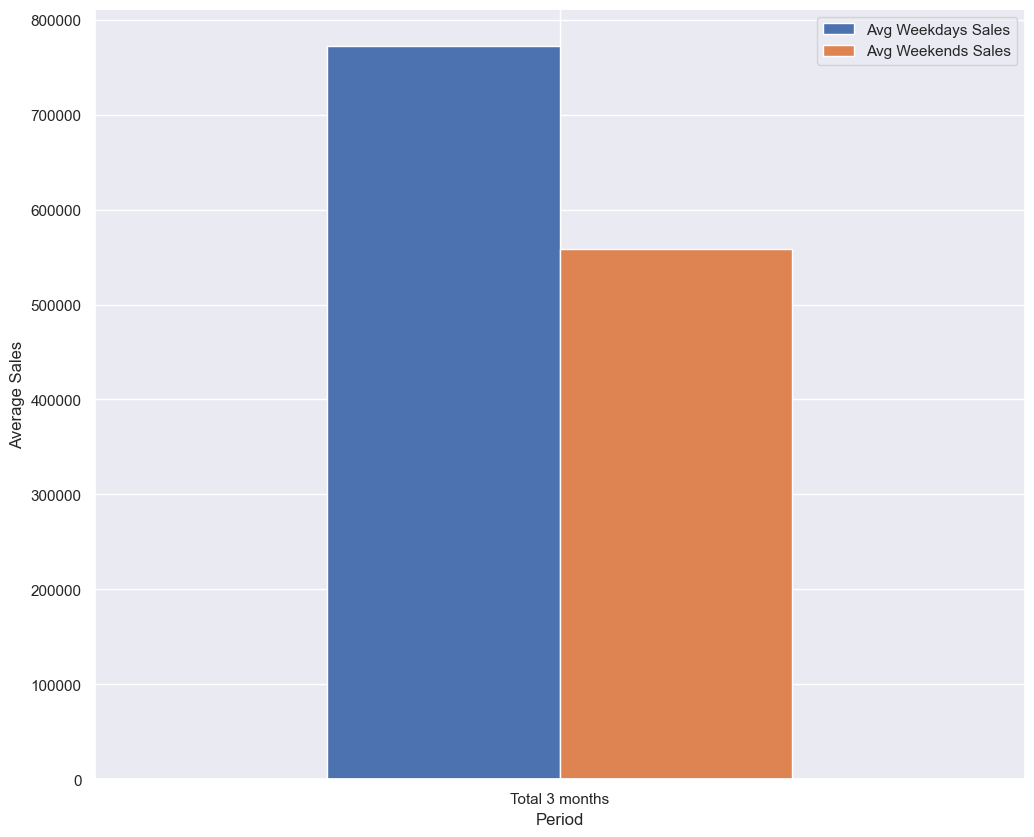

In [31]:
# plot the data
sns.set()
compare_avg_weekends_weekdays.plot(x='Period',
                                  y=['Avg Weekdays Sales','Avg Weekends Sales'],
                                  kind='bar',
                                  grid = True,
                                  # xlabel = 'Month Name',
                                  ylabel = 'Average Sales',
                                  figsize=(12,10),
                                  rot = 0,  # for rotate the text in xlabel
                                  table = False,
                                  secondary_y = False)

In [32]:
"""Question 5
Finding Products with the Largest Decrease in Sales Between Two Periods (e.g., 2022 vs 2021) Scenario:
 The Sales Team would like to identify which products had the most significant decrease in sales between two periods (e.g., 2021 and 2022). 
 Requirements: 1. Create two datasets for each period (e.g., 2021 and 2022), aggregated by product (sku_name). 
 2. Calculate the sales difference between the two periods.
 3. Identify the products with the largest decrease in sales and show the top 10 products. 
 4. Create a bar chart to visualize the products with the largest decrease in sales.
 Key Features to Use: • sku_name (for product names) • order_date (for filtering by year) • qty_ordered (for sales data)
"""

'Question 5\nFinding Products with the Largest Decrease in Sales Between Two Periods (e.g., 2022 vs 2021) Scenario:\n The Sales Team would like to identify which products had the most significant decrease in sales between two periods (e.g., 2021 and 2022). \n Requirements: 1. Create two datasets for each period (e.g., 2021 and 2022), aggregated by product (sku_name). \n 2. Calculate the sales difference between the two periods.\n 3. Identify the products with the largest decrease in sales and show the top 10 products. \n 4. Create a bar chart to visualize the products with the largest decrease in sales.\n Key Features to Use: • sku_name (for product names) • order_date (for filtering by year) • qty_ordered (for sales data)\n'

In [36]:
#Calculating the sales for 2021 
Sales_2021 = pd.DataFrame(\
                    
                         
                            # filtering the columns as needed 
                           df[  (df['is_valid']==1) & (df['order_date'].dt.year == 2021)]\
                           # groupby quantity
                           .groupby(by=['sku_name','category'])['qty_ordered'].sum()\
                           # convert to dataframe
                           .reset_index(name='Sales_2021')
                           #renaming the columns
                           .rename(columns={
                                             'sku_name': 'Product_Name'})
                           # sorting the values from the largest to the smallest
                           .sort_values(by='Sales_2021', ascending=False)\
                          )
#Calculating the sales for 2022
Sales_2022 = pd.DataFrame(\
                           # filtering the columns as needed 
                           df[  (df['is_valid']==1) & (df['order_date'].dt.year == 2022)]\
                           # groupby quantity
                           .groupby(by=['sku_name','category'])['qty_ordered'].sum()\
                           # convert to dataframe
                           .reset_index(name='Sales_2022')
                           #renaming the columns
                           .rename(columns={
                                             'sku_name': 'Product_Name'})
                           # sorting the values from the largest to the smallest
                           .sort_values(by='Sales_2022', ascending=False)\
                           )

#merging the dataframes
Sales_2021_2022 = Sales_2021.merge(Sales_2022[['Product_Name', 'Sales_2022']], how='inner')

Sales_2021_2022

,Product_Name,category,Sales_2021,Sales_2022
0,RB_Dettol Germ Busting Kit-bf,Others,400,80
1,RS_Baklawa 500gm,Soghaat,214,36
2,jn_900g,Superstore,104,20
3,RS_Soan Papri-250gm,Soghaat,102,14
4,Topline_Waheed Murad His Life and Our Times,Books,82,20
...,...,...,...,...
161,s_tv_KLV-40R352C,Entertainment,2,4
162,HOS-W_VSBSIBEDP100,Beauty & Grooming,2,6
163,timex_T20501,Men Fashion,2,2
164,timex_T46681,Men Fashion,2,4


In [39]:
#Calculating and adding the column for sales  difference
Sales_2021_2022['Sales_Diff'] = Sales_2021_2022['Sales_2022'] - Sales_2021_2022['Sales_2021']

# sorting the values from the smallest to largest
Sales_2021_2022.sort_values(by='Sales_Diff', ascending=True, inplace=True)


Sales_2021_2022

,Product_Name,category,Sales_2021,Sales_2022,Sales_Diff
0,RB_Dettol Germ Busting Kit-bf,Others,400,80,-320
1,RS_Baklawa 500gm,Soghaat,214,36,-178
3,RS_Soan Papri-250gm,Soghaat,102,14,-88
2,jn_900g,Superstore,104,20,-84
4,Topline_Waheed Murad His Life and Our Times,Books,82,20,-62
...,...,...,...,...,...
102,PNG_Pampers_10003452-Hazir,Superstore,2,44,42
72,RS_Nimcolia-5pack,Soghaat,4,58,54
36,un_Green Tea Bundle_GT,Superstore,10,64,54
42,emart_Tyre Shape Air Compressor,Others,10,68,58


In [38]:
#selecting top 10 rows
top_10_products = Sales_2021_2022.head(10)
top_10_products

,Product_Name,category,Sales_2021,Sales_2022,Sales_Diff
0,RB_Dettol Germ Busting Kit-bf,Others,400,80,-320
1,RS_Baklawa 500gm,Soghaat,214,36,-178
3,RS_Soan Papri-250gm,Soghaat,102,14,-88
2,jn_900g,Superstore,104,20,-84
4,Topline_Waheed Murad His Life and Our Times,Books,82,20,-62
7,Telemall_MM-DR-HB-L,Others,46,4,-42
5,RS_Kaju Barfi,Soghaat,58,20,-38
12,BB_bundle_bf,Superstore,34,2,-32
9,Al Muhafiz Sohan Halwa Cashew,Soghaat,40,12,-28
14,RS_Double Delight,Soghaat,28,4,-24


C:\Users\Siva Niharika Reddy\AppData\Local\Temp\ipykernel_27588\355368819.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_products.sort_values(by='Sales_Diff', ascending=True, inplace=True)


<Axes: title={'center': 'TOP 5 Products'}, xlabel='Product Name', ylabel='Sales'>

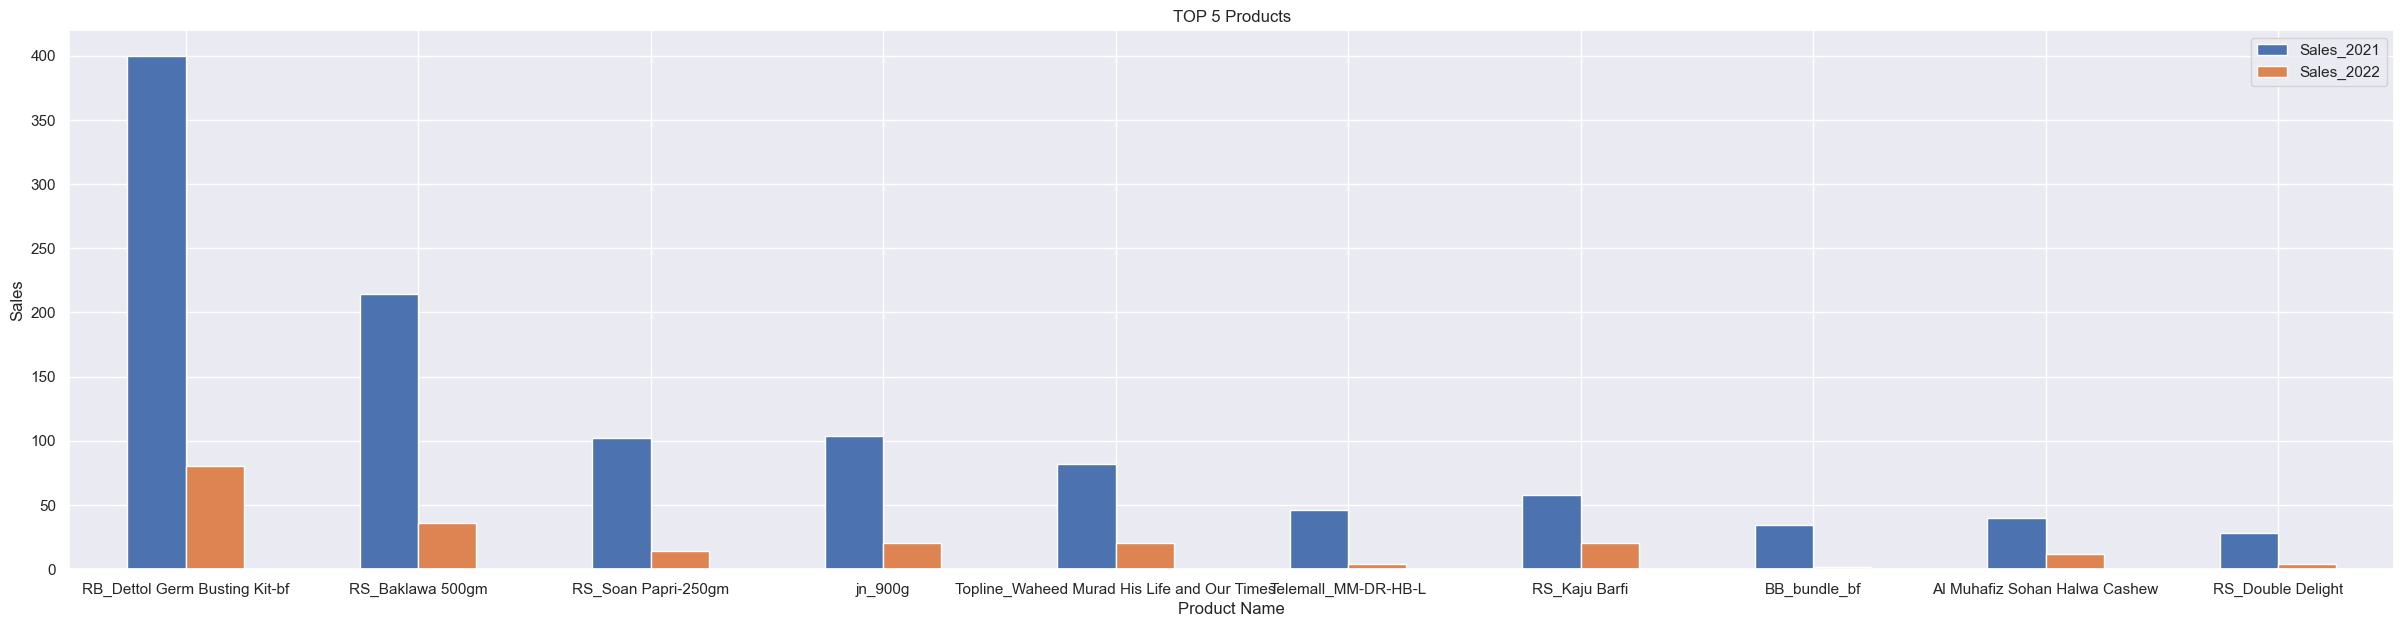

In [175]:
## sorting the values from the largest to the smallest
top_10_products.sort_values(by='Sales_Diff', ascending=True, inplace=True)

# plot the data
top_10_products.plot(x='Product_Name',
           y=['Sales_2021','Sales_2022'],
           kind='bar', # barh for horizontal bar chart
           grid = True,
           xlabel = 'Product Name',
           ylabel = 'Sales',
           figsize=(30,7),
           rot = 0,
           title = 'TOP 5 Products',
           table = False,
           secondary_y = False)





In [77]:
"""Question 6

Comparing Sales Trends for Multiple Categories in 2022 Scenario: 
The Marketing Team wants to compare the sales trends for multiple categories in 2022 to identify which category performed best. 
Requirements: 1. Aggregate the sales data by category for 2022.
 2. Plot a time series of sales trends for each category (use order_date to group by month or week). 
 3. Provide insights on which category had the highest sales growth. 
 Key Features to Use: • category • order_date (for time series analysis) • qty_ordered
 """

'Question 6\n\nComparing Sales Trends for Multiple Categories in 2022 Scenario: \nThe Marketing Team wants to compare the sales trends for multiple categories in 2022 to identify which category performed best. \nRequirements: 1. Aggregate the sales data by category for 2022.\n 2. Plot a time series of sales trends for each category (use order_date to group by month or week). \n 3. Provide insights on which category had the highest sales growth. \n Key Features to Use: • category • order_date (for time series analysis) • qty_ordered\n '

In [5]:
#Calculating the sales for 2022
Sales_2022 = (
    df[
        # filtering the columns as needed
        (df['is_valid'] == 1) &
        (df['order_date'].dt.year == 2022)
    ]
    # groupby quantity
    .groupby(by=['category'], as_index=False)['qty_ordered'].sum()
    #renaming the columns
    .rename(columns={'qty_ordered': 'Sales_2022'})
    # sorting the values from the largest to the smallest
    .sort_values(by='Sales_2022', ascending=False)
    # convert to dataframe
    .reset_index(drop=True)
)
Sales_2022

NameError: name 'df' is not defined

In [124]:
#
df['order_date'] = pd.to_datetime(df['order_date'], errors='coerce')
df_2022 = df[(df['is_valid'] == 1) & (df['order_date'].dt.year == 2022)].copy()
df_2022 = df[(df['is_valid'] == 1) & (df['order_date'].dt.year == 2022)]


In [4]:
#
sales_trend = (
    df_2022
    .set_index('order_date')
    .groupby([pd.Grouper(freq='M'), 'category'])['qty_ordered']
    .sum()
    .reset_index()
)

NameError: name 'df_2022' is not defined

In [3]:
sales_pivot = sales_trend.pivot(index='order_date', columns='category', values='qty_ordered').fillna(0)
sales_pivot


NameError: name 'sales_trend' is not defined

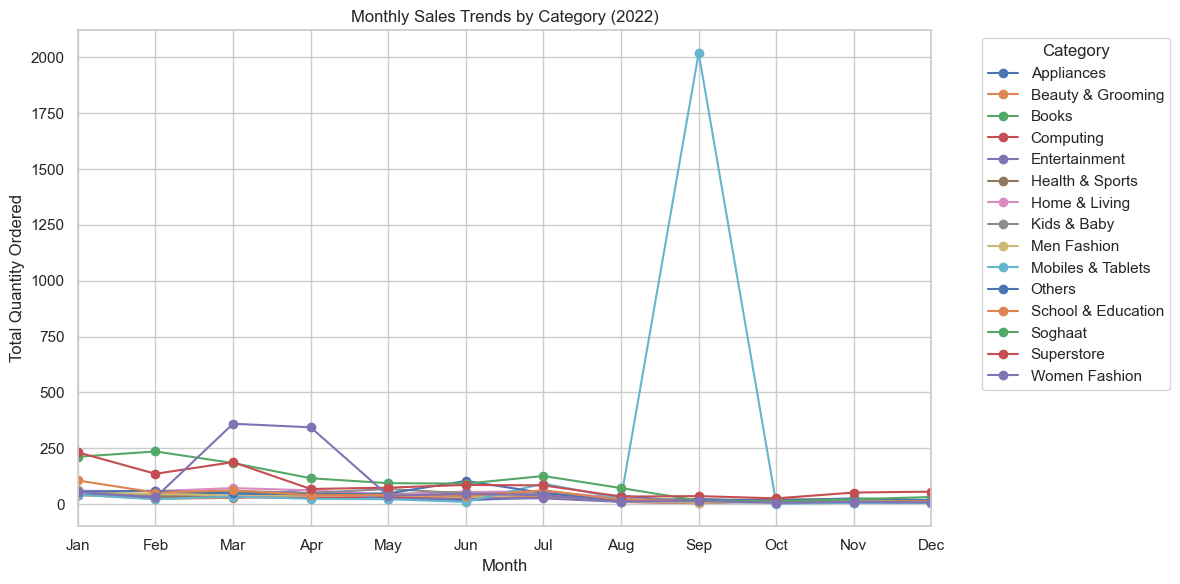

In [131]:
#
sns.set(style="whitegrid")
sales_pivot.plot(kind='line', figsize=(12, 6), marker='o')

plt.title('Monthly Sales Trends by Category (2022)')
plt.xlabel('Month')
plt.ylabel('Total Quantity Ordered')
plt.xticks(sales_pivot.index, [d.strftime('%b') for d in sales_pivot.index], rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [154]:
#Task 1
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_5_products.csv"  # Update with your desired folder path

# Save to CSV
Top_5_products.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_5_products.csv


In [172]:
#Task 2
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_20_Products.csv"  # Update with your desired folder path

# Save to CSV
Top_20_Products.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_20_Products.csv


In [179]:
#Task 4
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\compare_avg_weekends_weekdays.csv"  # Update with your desired folder path

# Save to CSV
compare_avg_weekends_weekdays.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\compare_avg_weekends_weekdays.csv


In [176]:

#Task 5
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_10_Products.csv"  # Update with your desired folder path

# Save to CSV
top_10_products.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

File successfully saved to C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Top_10_Products.csv


In [2]:
#Task 6
file_path = r"C:\Users\Siva Niharika Reddy\Documents\Niharika\DATA ANALYTICS\DA Internship(nullclass)\Sales_2022.csv"  # Update with your desired folder path

# Save to CSV
sales_pivot.to_csv(file_path, index=False)

print(f"File successfully saved to {file_path}")

NameError: name 'sales_pivot' is not defined